Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


Dataset

In [8]:
train_dir = "../data/train"
test_dir = "../data/test"

print("Train path:", train_dir)
print("Test path:", test_dir)


Train path: ../data/train
Test path: ../data/test


Data Transforms

In [9]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


Load Datasets

In [10]:
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
test_data = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
class_names


['Acura',
 'Alfa Romeo',
 'Aston Martin',
 'Audi',
 'BMW',
 'Bentley',
 'Bugatti',
 'Buick',
 'Cadillac',
 'Chevrolet',
 'Chrysler',
 'Citroen',
 'Daewoo',
 'Dodge',
 'Ferrari',
 'Fiat',
 'Ford',
 'GMC',
 'Genesis',
 'Honda',
 'Hudson',
 'Hyundai',
 'Infiniti',
 'Jaguar',
 'Jeep',
 'Kia',
 'Land Rover',
 'Lexus',
 'Lincoln',
 'MG',
 'Maserati',
 'Mazda',
 'Mercedes-Benz',
 'Mini',
 'Mitsubishi',
 'Nissan',
 'Oldsmobile',
 'Peugeot',
 'Pontiac',
 'Porsche',
 'Ram Trucks',
 'Renault',
 'Saab',
 'Studebaker',
 'Subaru',
 'Suzuki',
 'Tesla',
 'Toyota',
 'Volkswagen',
 'Volvo']

Build Model

In [11]:
model = models.resnet18(weights=None)  # No pretrained weights
model.fc = nn.Linear(model.fc.in_features, len(class_names))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


Training Function

In [12]:
def train_model(model, loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader)}")

    return model


Train the Model

In [13]:
model = train_model(model, train_loader, epochs=5)


Epoch 1/5, Loss: 3.9793445234713345
Epoch 2/5, Loss: 3.8434557064719823
Epoch 3/5, Loss: 3.750819906981095
Epoch 4/5, Loss: 3.6829442936441175
Epoch 5/5, Loss: 3.623246103784312


Evaluation

In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))


               precision    recall  f1-score   support

        Acura       0.00      0.00      0.00        18
   Alfa Romeo       0.14      0.06      0.08        18
 Aston Martin       0.00      0.00      0.00        19
         Audi       0.00      0.00      0.00        18
          BMW       0.00      0.00      0.00        17
      Bentley       0.00      0.00      0.00        19
      Bugatti       0.06      0.47      0.11        19
        Buick       0.00      0.00      0.00        19
     Cadillac       0.00      0.00      0.00        18
    Chevrolet       0.00      0.00      0.00        18
     Chrysler       0.00      0.00      0.00        18
      Citroen       0.06      0.05      0.06        19
       Daewoo       0.00      0.00      0.00        21
        Dodge       0.00      0.00      0.00        17
      Ferrari       0.26      0.30      0.28        20
         Fiat       0.00      0.00      0.00        18
         Ford       0.00      0.00      0.00        18
         

C:\Users\Latitude\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Latitude\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Latitude\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

Confusion Matrix

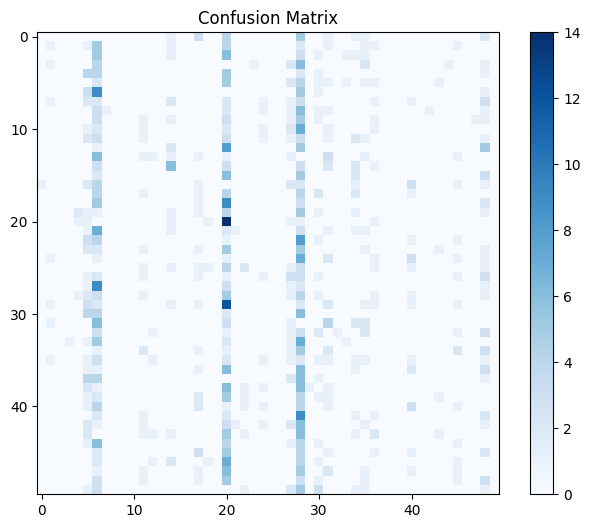

In [15]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()


Save Model

In [17]:
torch.save(model.state_dict(), "../models/car_model.pth")
print("Model saved!")


Model saved!


Single Image Prediction

In [21]:
from PIL import Image
import torch
import glob
import random

# Function to predict a single image
def predict_image(path):
    img = Image.open(path).convert("RGB")
    img_t = transform_test(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_t)
        _, pred = torch.max(output, 1)

    return class_names[pred.item()]

# Function to get a random image from test dataset
def get_random_test_image():
    # Get all class folders in test
    folders = glob.glob("../data/test/*")
    # Pick a random folder (class)
    random_folder = random.choice(folders)
    # Pick a random image from that folder
    images = glob.glob(random_folder + "/*")
    return random.choice(images)

# Pick a random test image
random_image = get_random_test_image()
print("Random image selected:", random_image)

# Predict the class
predicted_class = predict_image(random_image)
print("Predicted class:", predicted_class)
 # change to any image path


Random image selected: ../data/test\Volvo\Volvo_018.jpg
Predicted class: Lexus
